# 戴口罩偵測

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np


In [2]:
# 預先訓練好的模型 -- VGG16, 不含後三層(辨識層)
base_model = VGG16(weights='imagenet', include_top=False)

# 連接自訂層
x = base_model.output
#x = layers.Flatten()(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(2, activation='sigmoid')(x)

# 設定新模型的 inputs/outputs
model = Model(inputs=base_model.input, outputs=x)

# VGG16 原有的層均不重新訓練
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='binary_crossentropy')    

In [4]:
# 讀取 data 目錄下所有圖檔
from os import listdir
from os.path import isfile, join
from os import path

if not path.exists("mask.npy"):
    # 讀取 data/with_mask 目錄下所有圖片檔名
    img_path = './data/with_mask/'
    image_files = np.array([join(img_path, f) for f in listdir(img_path) if isfile(join(img_path, f)) and f[-3:] == 'jpg'])

    # 讀取 data/without_mask 目錄下所有圖片檔名
    img_path = './data/without_mask/'
    image_files2 = np.array([join(img_path, f) for f in listdir(img_path) if isfile(join(img_path, f)) and f[-3:] == 'jpg'])


In [5]:
# 讀取 data 目錄下所有圖檔
if not path.exists("mask.npy"):
    X = np.array([])
    # 讀取 data/without_mask 目錄下所有圖檔
    for f in image_files2:
        # 載入圖檔，並縮放寬高為 (224, 224) 
        img = image.load_img(f, target_size=(224, 224))
        # 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
        img2 = image.img_to_array(img)
        img2 = np.expand_dims(img2, axis=0)
        if len(X.shape) == 1:
            X = img2
        else:
            # 合併每個圖檔的像素
            X = np.concatenate((X, img2), axis=0)

    # 讀取 data/with_mask 目錄下所有圖檔
    for f in image_files:
        # 載入圖檔，並縮放寬高為 (224, 224) 
        img = image.load_img(f, target_size=(224, 224))
        # 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
        img2 = image.img_to_array(img)
        img2 = np.expand_dims(img2, axis=0)
        if len(X.shape) == 1:
            X = img2
        else:
            X = np.concatenate((X, img2), axis=0)

    X = preprocess_input(X)
    
    np.save('mask', X)


In [6]:
# 產生 label， with_mask = 1， without_mask = 0
if not path.exists("mask_y.npy"):
    from tensorflow.keras.utils import to_categorical

    y = np.concatenate((np.zeros(image_files2.shape[0]), np.ones(image_files.shape[0])))
    # one-hot encoding
    y = to_categorical(y, num_classes=2)
    
    np.save('mask_y', y)

In [7]:
if path.exists("mask.npy"):
    X = np.load("mask.npy")
if path.exists("mask_y.npy"):
    y = np.load("mask_y.npy")
    

In [8]:
X.shape, y.shape

((1376, 224, 224, 3), (1376, 2))

In [9]:
model.fit(X, y, epochs=5, validation_split=0.2, verbose=2)

Epoch 1/5
35/35 - 14s - loss: 0.1154 - val_loss: 0.0609
Epoch 2/5
35/35 - 11s - loss: 0.0148 - val_loss: 0.2507
Epoch 3/5
35/35 - 11s - loss: 0.0137 - val_loss: 0.1290
Epoch 4/5
35/35 - 11s - loss: 0.0229 - val_loss: 0.0036
Epoch 5/5
35/35 - 11s - loss: 0.0245 - val_loss: 0.0229


戴口罩機率：99.98


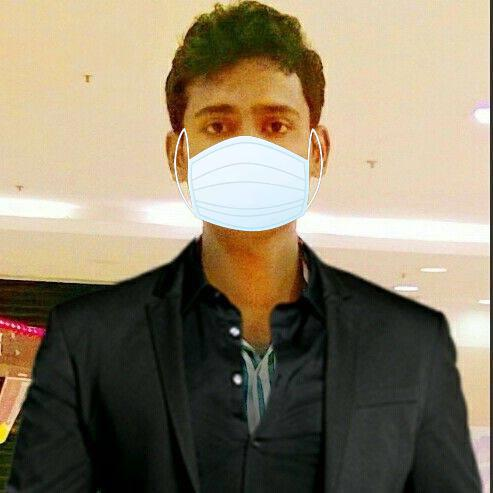

In [25]:
# 任意一張圖片測試
img_path = './0_images/with-mask.jpg'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))
# 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(f'戴口罩機率：{round(model.predict(x)[0][1] * 100, 2):.2f}')

from IPython.display import Image
Image(img_path, width=200)

戴口罩機率：0.00


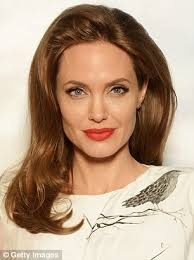

In [26]:
# 任意一張圖片測試
img_path = './0_images/without-mask.jpg'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))
# 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(f'戴口罩機率：{round(model.predict(x)[0][1] * 100, 2):.2f}')

from IPython.display import Image
Image(img_path, width=200)

In [24]:
model.save('mask_model.h5')